In [1]:
import sympy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nmp_util
from IPython.display import display
sns.set_theme()

In [2]:
r_sym, phi_sym = sympy.symbols('r, phi')

# expression for the variable transformation f
f_expr = sympy.Matrix([
    r_sym*sympy.cos(phi_sym), 
    r_sym*sympy.sin(phi_sym)
])

display(f_expr)
print(sympy.latex(f_expr))
formula, K = nmp_util.error_propagation_formula(f_expr,[r_sym,phi_sym])

display(formula)
print(sympy.latex(formula))

k11, k22 = sympy.symbols('k11, k22')
diagonal_k = sympy.diag([k11,k22], unpack=True)

#doit is necessary to perform matmul
formula = formula.subs({K:diagonal_k}).doit() 

display(formula)
print(sympy.latex(formula))

Matrix([
[r*cos(phi)],
[r*sin(phi)]])

\left[\begin{matrix}r \cos{\left(\phi \right)}\\r \sin{\left(\phi \right)}\end{matrix}\right]


Matrix([
[cos(phi), -r*sin(phi)],
[sin(phi),  r*cos(phi)]])*K*Matrix([
[   cos(phi),   sin(phi)],
[-r*sin(phi), r*cos(phi)]])

\left[\begin{matrix}\cos{\left(\phi \right)} & - r \sin{\left(\phi \right)}\\\sin{\left(\phi \right)} & r \cos{\left(\phi \right)}\end{matrix}\right] K \left[\begin{matrix}\cos{\left(\phi \right)} & \sin{\left(\phi \right)}\\- r \sin{\left(\phi \right)} & r \cos{\left(\phi \right)}\end{matrix}\right]


Matrix([
[            k11*cos(phi)**2 + k22*r**2*sin(phi)**2, k11*sin(phi)*cos(phi) - k22*r**2*sin(phi)*cos(phi)],
[k11*sin(phi)*cos(phi) - k22*r**2*sin(phi)*cos(phi),             k11*sin(phi)**2 + k22*r**2*cos(phi)**2]])

\left[\begin{matrix}k_{11} \cos^{2}{\left(\phi \right)} + k_{22} r^{2} \sin^{2}{\left(\phi \right)} & k_{11} \sin{\left(\phi \right)} \cos{\left(\phi \right)} - k_{22} r^{2} \sin{\left(\phi \right)} \cos{\left(\phi \right)}\\k_{11} \sin{\left(\phi \right)} \cos{\left(\phi \right)} - k_{22} r^{2} \sin{\left(\phi \right)} \cos{\left(\phi \right)} & k_{11} \sin^{2}{\left(\phi \right)} + k_{22} r^{2} \cos^{2}{\left(\phi \right)}\end{matrix}\right]


(2, 2, 20, 20)
(20, 20, 2, 2)


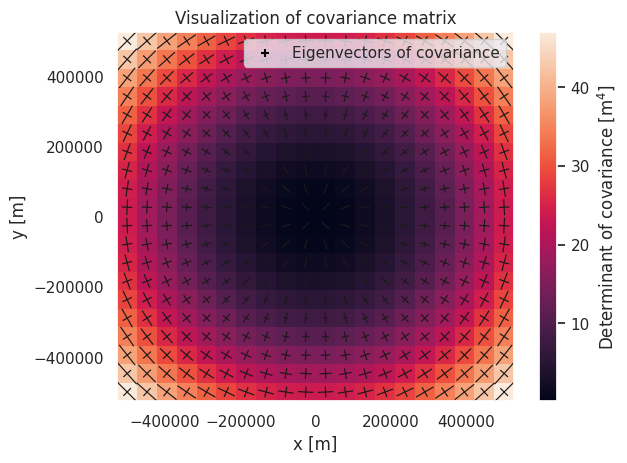

In [3]:
_x = np.linspace(-500_000,500_000, 20)
_y = np.linspace(-500_000,500_000, 20)

x, y = np.meshgrid(_x, _y)

# polar coordinates for further calculations
r = np.sqrt(x**2 + y**2)
phi = np.atan2(y, x)

r_cov = 2**2 # m
phi_cov = np.deg2rad(1/3600)**2 # 1''

# compute covariances via formula from previous cell
covariance_lambda = sympy.lambdify([k11, k22, r_sym, phi_sym], formula)
covariances = covariance_lambda(r_cov, phi_cov,r,phi)

print(covariances.shape)
#we need to rotate the axis beacause np.linalg expects a shape (...,m,n)
covariances = np.moveaxis(covariances, [0,1], [2,3])

print(covariances.shape)

plt.figure()
plt.title('Visualization of covariance matrix')
nmp_util.matrix_quiver(x, y, covariances, shade_determinant=True, label = 'Eigenvectors of covariance', det_label='Determinant of covariance [m$^4$]')
plt.legend()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

In [4]:
import pandas as pd


campPP_df = pd.read_csv('data/campPP_mar2024.dat', names = ['angle [°]', 'r [m]'], index_col=False, sep = r'\s+', skiprows=1).astype(float)
display(campPP_df)

,angle [°],r [m]
0,-57.710656,49.876905
1,-17.562529,69.866607
2,-5.648522,107.096015
3,-2.265576,133.324216
4,-0.755542,159.877900
5,0.000000,186.508000
6,3.123464,193.456391
7,6.449076,187.695724
8,14.775243,165.330885
9,21.584930,143.266833


xy_vals is an array of 2x1 column vectors (2, 1, 39)


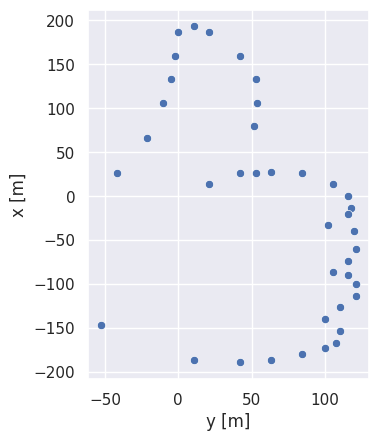

In [5]:
f_lambda = sympy.lambdify([phi_sym, r_sym],f_expr)
xy_vals = f_lambda(np.deg2rad(campPP_df['angle [°]']), campPP_df['r [m]'])
print(f'xy_vals is an array of 2x1 column vectors {xy_vals.shape}')
campPP_df['x [m]'] = xy_vals[0,0,:]
campPP_df['y [m]'] = xy_vals[1,0,:]
plt.axes().set_aspect(0.6)
sns.scatterplot(campPP_df, x = 'y [m]', y = 'x [m]')
plt.show()

# Create covariance matrix as $2n \times 2n$ matix

(2, 2, 39)
(39, 2, 2)


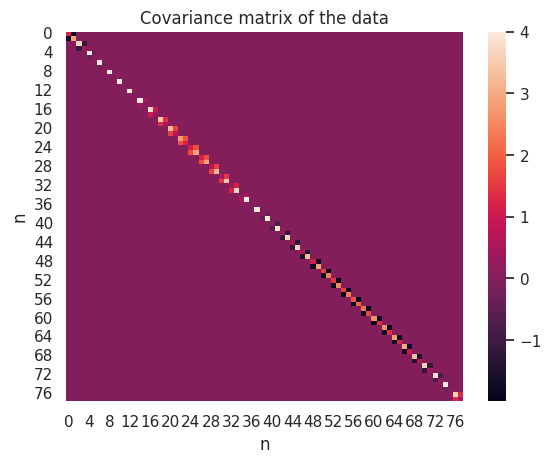

In [6]:
from scipy.linalg import block_diag

covariances  : np.ndarray = covariance_lambda(r_cov, phi_cov, campPP_df['r [m]'], np.deg2rad(campPP_df['angle [°]']))


print(covariances.shape)

# block_diag expects a list of 2x2 matrices, so we need to swap the axes
covariances = covariances.swapaxes(2,0)
print(covariances.shape)

covariance_matrix = block_diag(*covariances)

plt.title('Covariance matrix of the data')
sns.heatmap(covariance_matrix)
plt.xlabel('n')
plt.ylabel('n')
plt.show()

xy_vals is an array of 2x1 column vectors (2, 1, 39)


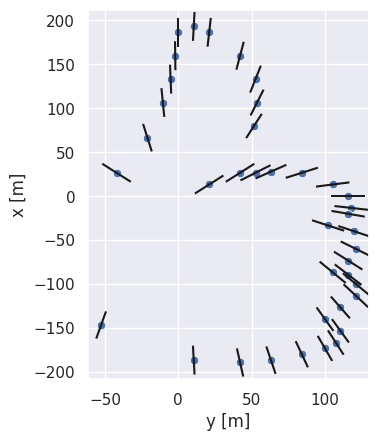

In [7]:
f_lambda = sympy.lambdify([phi_sym, r_sym],f_expr)
xy_vals = f_lambda(np.deg2rad(campPP_df['angle [°]']), campPP_df['r [m]'])
print(f'xy_vals is an array of 2x1 column vectors {xy_vals.shape}')
campPP_df['x [m]'] = xy_vals[0,0,:]
campPP_df['y [m]'] = xy_vals[1,0,:]
plt.axes().set_aspect(0.6)
# reverse the covariance matrix because of i swapped the x, y axes
sns.scatterplot(campPP_df, x = 'y [m]', y = 'x [m]')
nmp_util.matrix_quiver(campPP_df['y [m]'],campPP_df['x [m]'], covariances[:,::-1,::-1], label = 'Variance')
plt.show()